### Numerical Experiments

Visualization of the sparse grid optimization

In [1]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)

def from_standard(lower, upper, value):
    return value*(upper-lower)+lower


def to_standard_log(lower, upper, value):
    a = math.log10(upper/lower)
    return math.log10(value/lower) / a

def from_standard_log(lower, upper, value):
    a = math.log10(upper/lower)
    return lower * 10**(a*value)

BUDGET = 100
VERBOSE = 1
CV = [(slice(None), slice(None))]
SCORING = 'neg_mean_squared_error'
TESTING = False

DATASETS = []


2023-04-19 14:24:36.421055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 14:24:37.857821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
hyperparameterspace = {
    'epochs': ["interval-int", 1, 30],
    #'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.01],
    #'model__neurons_per_layer': ["interval-int", 1, 100],
    #'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

Adaptive grid generation (Ritter-Novak)...


2023-04-19 14:24:45.399836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Done in 247404ms.


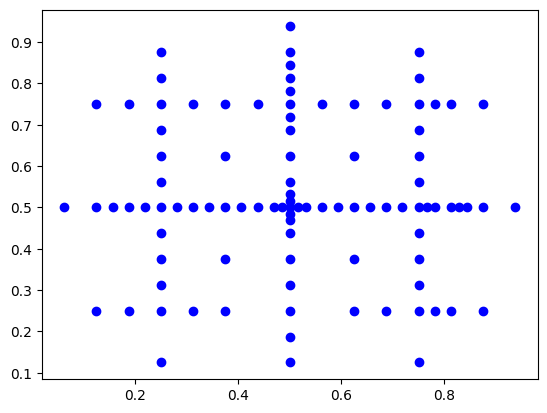

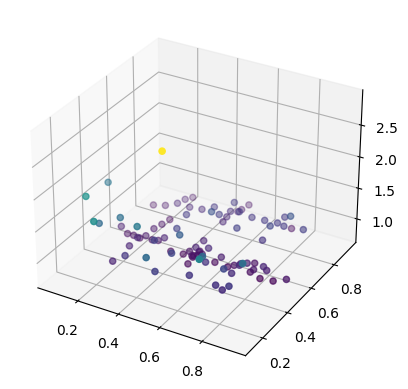

Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 24.5625
optimizer__learning_rate: 3.1622776601683795e-05
Resulting loss:
0.7652405254785047
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 26.982898922722455
optimizer__learning_rate: 3.1622776601683795e-05
Resulting loss (Optimal value from optimization):
0.4182910911623885
Resulting loss (Optimal point evaluated):
0.9610148596112229
Before optimization: 1.400481101613486
After optimization: 1.1267857627243705


In [3]:
ids = [233214]#, 233211]#, 359935]#, 359952, 359940, 359931, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

RESULTS_datasets = [[] for _ in range(len(ids))]

dataset = HPO.Dataset(task_id=233214)

class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


    def eval(self, x):
        #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
        
        epochs = int(from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

        batch_size = 120# int(from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

        model_learning_rate = from_standard_log(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[1])
        
        neurons_per_layer = 40 # int(from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

        number_of_layers = 2 # int(from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
            for _ in range(number_of_layers):
                model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer,)
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

        if TESTING:
            Y_predicted = model.predict(dataset.get_X_test())
            result = sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
            K.clear_session()
            return result
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            result = sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
            K.clear_session()
            return result


results_temp = []
results_opt_temp = []

sparse_params=[3, 0.95, "gradient_descent"]

f = ExampleFunction()

optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=sparse_params[0], adaptivity=sparse_params[1], optimizer=sparse_params[2])

result = optimization.fit()

TESTING = True
result_not_optimized = f.eval(result[0])
result_optimized = f.eval(result[1])
TESTING = False

print("Before optimization:", result_not_optimized)
print("After optimization:", result_optimized)
